In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time

#### Setup Device

In [3]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

mps


#### Load and Normalize CIFAR-10 Data

In [4]:
batch_size = 256

mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2009, 0.2009, 0.2009])
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean = mean, std = std)])
cifar_train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
cifar_test_data = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)

cifar_train_dl = torch.utils.data.DataLoader(cifar_train_data, batch_size=batch_size, shuffle=True)
cifar_test_dl = torch.utils.data.DataLoader(cifar_test_data, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


## Define Convolutional Neural Networks

### Baseline

In [34]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Flatten()
        )
        self.classifier = nn.Linear(in_features=128*4*4, out_features=10)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
class ConvNet_Simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=3),
            nn.GroupNorm(128, 128, eps=1e-05, affine=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(128, 128, eps=1e-05, affine=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(128, 128, eps=1e-05, affine=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.classifier = nn.Linear(in_features=2048, out_features=10, bias=True)

    def forward(self, x):
            x = self.features(x)
            x = x.view(x.shape[0], -1)
            x = self.classifier(x)
            return x

### Double Layers

In [36]:
class BaselineCNN_DL(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Flatten()
        )
        self.classifier = nn.Linear(in_features=128*4*4, out_features=10)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Dropout Regularization

In [44]:
class CNN_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(0.4),
            nn.Flatten()
        )
        self.classifier = nn.Linear(in_features=128*4*4, out_features=10)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### BatchNorm

In [45]:
class CNN_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(0.4),
            nn.Flatten()
        )
        self.classifier = nn.Linear(in_features=128*4*4, out_features=10)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### GroupNorm

In [64]:
class CNN_GN_Ch(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.GroupNorm(32, 32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.GroupNorm(32, 32),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.GroupNorm(32, 128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.GroupNorm(32, 128),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.GroupNorm(32, 512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.GroupNorm(32, 512),
            nn.AvgPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(0.4),
            nn.Flatten()
        )
        self.classifier = nn.Linear(in_features=512*4*4, out_features=10)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Scheduler Experiment

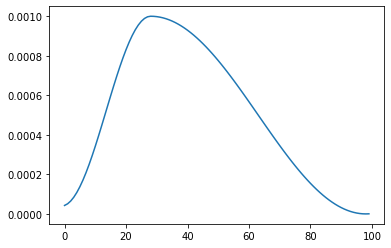

In [5]:
import matplotlib.pyplot as plt

model = torch.nn.Linear(in_features=10, out_features=10)
num_epochs=100
lrs = [0] * num_epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, epochs=num_epochs, steps_per_epoch=1)
loss_function = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    outputs = model(torch.randn(10, 10))
    loss = loss_function(outputs, torch.randint(0, 10, size=(10,)))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    lrs[epoch] = scheduler.get_last_lr()[0]


plt.plot(lrs)

## Train and test functions

In [38]:
from tqdm import tqdm

def train(model, num_epochs, train_dl=cifar_train_dl, test_dl=cifar_test_dl, optimizer="SGD", scheduler=True, verbose=False, patience=4):
    model.to(device)

    if optimizer == "SGD":
        lr = 0.05
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    else:
        lr = 0.001
        opt = torch.optim.AdamW(model.parameters(), lr, weight_decay=1e-4)

    if scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs)
        # scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, epochs=num_epochs, steps_per_epoch=1, div_factor=10)

    # Classification tasks should use cross entropy
    loss_function = nn.CrossEntropyLoss()

    test_accuracies = []
    train_accuracies = []
    best_test_accuracy = 0
    best_model_state_dict = None
    epochs_until_early_stop = patience

    train_start_time = time.time()
    epoch_progress_bar = tqdm(range(1, num_epochs + 1), desc="Training: ", unit="epoch")
    for epoch in epoch_progress_bar:
        model.train()
        epoch_start_time = time.time()

        for X, y in train_dl:
            X, y = X.to(device), y.to(device)

            predictions = model(X)
            loss = loss_function(predictions, y)

            opt.zero_grad()
            loss.backward()
            opt.step()
        
        if scheduler:
            scheduler.step()
        
        train_accuracy = test(model, train_dl)
        test_accuracy = test(model, test_dl)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        if scheduler:
            epoch_progress_bar.set_postfix(lr=scheduler.get_last_lr()[0], test_accuracy=test_accuracy)
        else:   
            epoch_progress_bar.set_postfix(test_accuracy=test_accuracy)
        epoch_total_time = time.time() - epoch_start_time
        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch:>03} took {epoch_total_time:.2f}s Test Acc: {test_accuracy:.4f}")

        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model_state_dict = model.state_dict()
            epochs_until_early_stop = patience
        else:
            epochs_until_early_stop -= 1
            if epochs_until_early_stop == 0:
                print('Model failing to improve on test data. Stopping early.')
                model.load_state_dict(best_model_state_dict)
                break
    
    total_train_time = time.time() - train_start_time
    final_test_accuracy = test(model, test_dl)
    
    print(f'Model achieved highest test accuracy of {final_test_accuracy:.4f}')
    print(f'Training took {total_train_time:.2f} seconds.')

    return train_accuracies, test_accuracies

def test(model, test_dl):
    model.to(device)
    model.eval()

    correct_predictions = 0
    total_predictions = 0
    
    # Testing, so no gradient computation is needed
    with torch.no_grad():
        for image, label in test_dl:
            image, label = image.to(device), label.to(device)

            predictions = model(image)
            _, predictions = torch.max(predictions, 1)

            correct_predictions += (predictions==label).sum().item()
            total_predictions += predictions.shape[0]
    
    return correct_predictions / total_predictions

## Evaluation

In [22]:
def plot_accuracy(title: str, training_accuracy: list, testing_accuracy: list) -> None:
    plt.title(title)
    plt.plot(training_accuracy, c='green')
    plt.plot(testing_accuracy, c='red')
    plt.show()
    

Training:  36%|███▌      | 18/50 [02:39<04:44,  8.88s/epoch, lr=0.000684, test_accuracy=0.765]


Model failing to improve on test data. Stopping early.
Model achieved highest test accuracy of 0.7647
Training took 159.85 seconds.


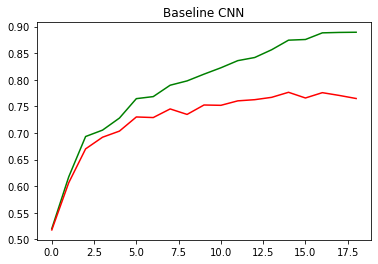

In [31]:
t, v = train(BaselineCNN(), 50, optimizer="AdamW", patience=4)
plot_accuracy("Baseline CNN", t, v)

Training:  46%|████▌     | 23/50 [06:32<07:40, 17.06s/epoch, lr=0.000531, test_accuracy=0.8]  


Model failing to improve on test data. Stopping early.
Model achieved highest test accuracy of 0.7997
Training took 392.37 seconds.


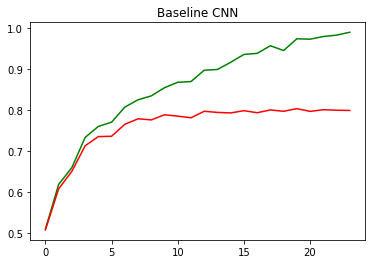

In [43]:
t, v = train(BaselineCNN_DL(), 50, optimizer="AdamW", patience=4)
plot_accuracy("Baseline CNN", t, v)

Training:  52%|█████▏    | 26/50 [07:31<06:56, 17.37s/epoch, lr=0.0219, test_accuracy=0.855]


Model failing to improve on test data. Stopping early.
Model achieved highest test accuracy of 0.8551
Training took 451.68 seconds.


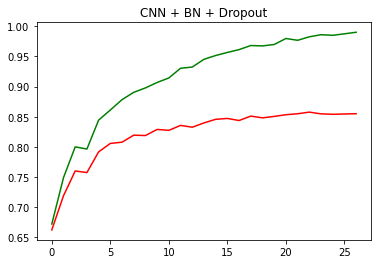

In [48]:
t, v = train(CNN_BN(), 50, patience=4)
plot_accuracy("CNN + BN + Dropout", t, v)

Training:  20%|██        | 20/100 [06:07<24:30, 18.38s/epoch, lr=0.000895, test_accuracy=0.854]


Model failing to improve on test data. Stopping early.
Model achieved highest test accuracy of 0.8536
Training took 367.65 seconds.


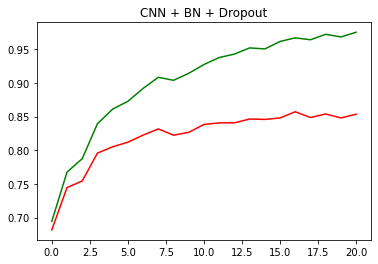

In [55]:
t, v = train(CNN_BN(), 100, patience=4, optimizer="AdamW")
plot_accuracy("CNN + BN + Dropout", t, v)

Training:  40%|████      | 40/100 [17:29<26:14, 26.25s/epoch, lr=0.000639, test_accuracy=0.852]


Model failing to improve on test data. Stopping early.
Model achieved highest test accuracy of 0.8523
Training took 1050.00 seconds.


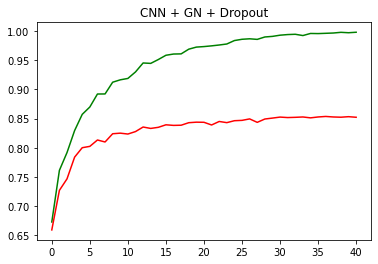

In [61]:
t, v = train(CNN_GN(), 100, patience=4, optimizer="AdamW")
plot_accuracy("CNN + GN + Dropout", t, v)

Training:  17%|█▋        | 17/100 [32:08<2:36:54, 113.43s/epoch, lr=0.000922, test_accuracy=0.848]


Model failing to improve on test data. Stopping early.
Model achieved highest test accuracy of 0.8481
Training took 1928.37 seconds.


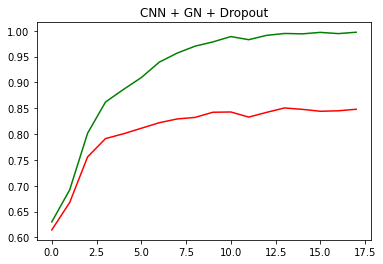

In [65]:
t, v = train(CNN_GN_Ch(), 100, patience=4, optimizer="AdamW")
plot_accuracy("CNN + GN + Dropout", t, v)